# 06 - Introduction to Neural Networks
Prepared by Jan Christian Blaise Cruz

DLSU Machine Learning Group

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

np.random.seed(42)
%matplotlib inline

# The MNIST Dataset

First, we fetch the original MNIST dataset. This will take a while to load.

In [ ]:
mnist = fetch_openml('mnist_784')

The dataset has 70k samples of handwritten numbers. Each number is an image that's 28x28 pixels. If you flatten the image into one vector, you get a vector of size 784.

In [ ]:
mnist.data.shape

(70000, 784)

We can reshape a data sample into its original shape.

In [ ]:
mnist.data[0].reshape(28, 28).shape

(28, 28)

Let's plot some samples.

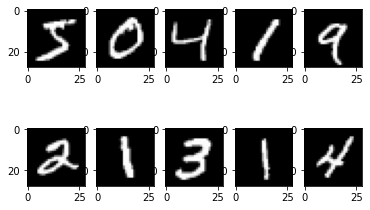

In [ ]:
fig, ax = plt.subplots(2, 5)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(mnist.data[i].reshape(28, 28), cmap='gray')

The correct labels for these numbers are the following.

In [ ]:
mnist.target[:10]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

As always, we first split into training and testing sets. We cast the data into floats to preserve memory, and the targets into integers since they're currently strings.

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(mnist.data.astype(np.float32), 
                                                    mnist.target.astype(np.int), 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52500, 784), (17500, 784), (52500,), (17500,))

# Minibatch Training

From this point, we will implement *Minibatch* stochastic gradient descent. Minibatching refers to dividing a training set into multiple small batches, then iterating over these batches every epoch. Since we apply gradient descent per batch, we essentially allow the model more room to "learn" by giving it multiple batches instead of feeding it the entire dataset at once.

This function yields a random batch from given inputs and targets.

In [ ]:
def batchify(inputs, targets, batch_size):
    indices = np.random.permutation(len(inputs))

    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        batch = indices[start_idx:start_idx + batch_size]
        yield inputs[batch], targets[batch]

Let's create dataloaders for the training and testing sets so we can iterate over them.

In [ ]:
bs = 32

train_loader = [b for b in batchify(X_train, y_train, bs)]
test_loader = [b for b in batchify(X_test, y_test, bs)]

We can check the first batch in a loader.

In [ ]:
x, y = train_loader[0]
print(x.shape, y.shape)

(32, 784) (32,)


In [ ]:
y

array([2, 7, 8, 3, 0, 8, 9, 9, 7, 4, 2, 4, 7, 9, 2, 4, 5, 7, 9, 2, 2, 3,
       6, 7, 9, 2, 8, 7, 4, 1, 9, 3])

# Basic Neural Networks

Let's implement a class for a neural network layer.

We include the weights and biases of the layer and give it functions for forward and backward propagation.

Forward propagation is straightforward. We apply a matrix multiplication then return the pre activation. We do not include the activation function within the class so we can do with the pre activations as we please.

Backward propagation, while a little more involved, is also quite simple. We compute for the weighted errors (new deltas), then get the gradients by applying a dot product with the activations of the previous layer.

We then apply a gradient descent step and return the new delta errors so we can pass this to the previous layer in the chain while backpropagating.

In [ ]:
class Linear:
    def __init__(self, input_dim, output_dim, learning_rate=3e-4):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros(output_dim)
        
    def forward(self, activations):
        return np.matmul(activations, self.weights) + self.biases
      
    def backward(self, grad_activations, delta):
        # Compute weighted errors
        new_delta = np.dot(delta, np.transpose(self.weights))

        # Dot product with gradient of activations
        grad_weights = np.transpose(np.dot(np.transpose(delta), grad_activations))
        grad_biases = np.sum(delta, axis=0)
        
        # Update weights
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return new_delta

We implement only one activation function, which is the rectified linear unit. The structure follows the structure of our linear layer.

In [ ]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, x):
        return np.maximum(0, x)

    def backward(self, grad_activations, delta):
        relu_grad = grad_activations > 0
        new_delta = delta * relu_grad 
        
        return new_delta

We can test out getting the pre activations using our linear layer.

In [ ]:
fc1 = Linear(784, 128)
relu = ReLU()

z = fc1.forward(x)
print(z.shape)
print(z)

(32, 128)
[[ 14.69895215  -5.61666568  -3.37829084 ...  12.41353805   0.59881915
   16.86491563]
 [ 16.00085381 -15.25398307  -0.17245634 ... -36.91130359 -23.10192512
  -11.97116324]
 [ -9.83528596 -30.70019511 -11.91590519 ...   3.92389971  -4.05055383
   12.99285493]
 ...
 [ 24.08741678 -15.22455756  22.05522407 ... -14.21536057  19.9951475
   11.62332957]
 [ -6.27261123  35.85141086   1.938583   ...  -5.74902129  -4.25501623
   21.33150014]
 [  8.64883446 -28.72850325 -16.14439628 ...  15.24779078  21.82864814
    6.29347996]]


And as expected, applying a relu will bound our pre activations between 0 and infinity.

In [ ]:
a = relu.forward(z)

print(a.shape)
print(a)

(32, 128)
[[14.69895215  0.          0.         ... 12.41353805  0.59881915
  16.86491563]
 [16.00085381  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  3.92389971  0.
  12.99285493]
 ...
 [24.08741678  0.         22.05522407 ...  0.         19.9951475
  11.62332957]
 [ 0.         35.85141086  1.938583   ...  0.          0.
  21.33150014]
 [ 8.64883446  0.          0.         ... 15.24779078 21.82864814
   6.29347996]]


# Softmax Cross Entropy

As for softmax, we do not implement it as a layer, but instead we incorporate it into our loss function. It is convention that we leave the final pre activations untouched so that we can use them should we need to (for example, chaining to another neural network or layer).

Anyhow, we implement a cross entropy loss function like this. Since we're handling multiple labels, we take the predicted logits for each correct label, then compute for the entropy. We introduce an epsilon value to prevent the logarithm from encountering a zero.



In [ ]:
def cross_entropy_loss(logits, y):
    # Get activations for correct answers (softmax), then compute cross-entropy 
    logits_for_labels = logits[np.arange(len(logits)), y]
    entropy = -logits_for_labels + np.log(np.sum(np.exp(logits) + 1e-18, axis=-1))
    
    return np.mean(entropy)

Likewise, we need to implement a version of the loss function for backpropagation. 

We subtract the softmaxed logits with the correct answers (which are expanded into a one-hot vector). This is our initial delta error.

In [ ]:
def grad_cross_entropy_loss(logits, y):
    # One-hot encode the correct answers
    one_hot = np.zeros_like(logits)
    one_hot[np.arange(len(logits)), y] = 1
    
    # Get the softmax
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    
    # Initial delta is the output - correct answer. Divide to get the mean.
    delta = (softmax - one_hot) / logits.shape[0]
    return delta

# Foward and Backpropagation

Let's write convenience functions for forward and back propagation.

Forward propagation is simple. We apply the forward function for all layers in our network, which is a list of layers.

In [ ]:
def forwardprop(network, x):
    activations = []

    # Pass through first layer
    out = network[0].forward(x)
    activations.append(out)

    # Forward prop through all layers 1 to L
    for i in range(1, len(network)):
        out = network[i].forward(out)
        activations.append(out)
        
    return activations

For backprop, we iterate from the last layer. Each layer and the activations of the previous layer are used.

In [ ]:
def backprop(network, logits, y):
    # Calculate the loss and initial delta
    loss = cross_entropy_loss(logits, y)
    delta = grad_cross_entropy_loss(logits, y)

    # Propagate delta backwards
    for i in range(1, len(network))[::-1]:
        delta = network[i].backward(activations[i - 1], delta)

    return loss

We also implement an accuracy function for convenience.

In [ ]:
def accuracy(logits, y):
    return np.sum(np.argmax(logits, 1) == y) / len(y)

Let's instantiate a simple one hidden layer network.

In [ ]:
network = [
    Linear(784, 128),
    ReLU(),
    Linear(128, 10),
]

Then sample a batch from the dataset.

In [ ]:
x, y = train_loader[0]

This gives us one run of forward and back propagation (with one step of gradient descent)

In [ ]:
# Forward Propagation
activations = forwardprop(network, x)
logits = activations[-1]
print("Shape of logits:", logits.shape)

# Backpropagation
loss = backprop(network, logits, y)
acc = accuracy(logits, y)
print("Loss {:.4f} | Accuracy {:.2f}%".format(loss, acc * 100))

Shape of logits: (32, 10)
Loss 3.5702 | Accuracy 18.75%


Another forward and backward pass shows us that our network is improving as the loss is going down.

In [ ]:
# Forward Propagation
activations = forwardprop(network, x)
logits = activations[-1]
print("Shape of logits:", logits.shape)

# Backpropagation
loss = backprop(network, logits, y)
acc = accuracy(logits, y)
print("Loss {:.4f} | Accuracy {:.2f}%".format(loss, acc * 100))

Shape of logits: (32, 10)
Loss 2.5923 | Accuracy 28.12%


# Putting it all Together

Let's reinstantiate our neural network and set a learning rate.

In [ ]:
network = [
    Linear(784, 128, learning_rate=3e-5),
    ReLU(),
    Linear(128, 10, learning_rate=3e-5),
]

We then train for 10 epochs. We iterate through each minibatch. For each minibatch, we perform forward and backward propagation, including one step of gradient descent to update our parameters. We log our loss and average per batch. We then take the average of the losses and accuracies.

In [ ]:
epochs = 10

for e in range(1, epochs + 1):
    # Training Loop
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        x, y = batch

        activations = forwardprop(network, x)
        logits = activations[-1]
        loss = backprop(network, logits, y)
        acc = accuracy(logits, y)

        train_loss += loss
        train_acc += acc
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Testing Loop
    test_loss = 0
    test_acc = 0
    for batch in tqdm(test_loader):
        x, y = batch

        activations = forwardprop(network, x)
        logits = activations[-1]
        loss = cross_entropy_loss(logits, y)
        acc = accuracy(logits, y)

        test_loss += loss
        test_acc += acc
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("\nEpoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

  8%|▊         | 130/1640 [00:00<00:01, 1298.57it/s]


Epoch   1 | Train Loss 1.1660 | Test Loss 0.7475 | Train Acc 63.60% | Test Acc 77.91%


  7%|▋         | 117/1640 [00:00<00:01, 1165.95it/s]


Epoch   2 | Train Loss 0.6588 | Test Loss 0.6145 | Train Acc 80.25% | Test Acc 81.79%


  8%|▊         | 130/1640 [00:00<00:01, 1299.76it/s]


Epoch   3 | Train Loss 0.5745 | Test Loss 0.5594 | Train Acc 82.83% | Test Acc 83.48%


  8%|▊         | 130/1640 [00:00<00:01, 1293.08it/s]


Epoch   4 | Train Loss 0.5326 | Test Loss 0.5275 | Train Acc 84.12% | Test Acc 84.55%


  8%|▊         | 130/1640 [00:00<00:01, 1292.31it/s]


Epoch   5 | Train Loss 0.5062 | Test Loss 0.5061 | Train Acc 84.87% | Test Acc 85.13%


  8%|▊         | 129/1640 [00:00<00:01, 1283.80it/s]


Epoch   6 | Train Loss 0.4876 | Test Loss 0.4906 | Train Acc 85.43% | Test Acc 85.53%


  7%|▋         | 120/1640 [00:00<00:01, 1195.71it/s]


Epoch   7 | Train Loss 0.4737 | Test Loss 0.4787 | Train Acc 85.84% | Test Acc 85.90%


  7%|▋         | 119/1640 [00:00<00:01, 1184.80it/s]


Epoch   8 | Train Loss 0.4627 | Test Loss 0.4692 | Train Acc 86.14% | Test Acc 86.23%


  8%|▊         | 128/1640 [00:00<00:01, 1271.18it/s]


Epoch   9 | Train Loss 0.4538 | Test Loss 0.4615 | Train Acc 86.39% | Test Acc 86.33%


100%|██████████| 546/546 [00:00<00:00, 1719.16it/s]


Epoch  10 | Train Loss 0.4464 | Test Loss 0.4551 | Train Acc 86.63% | Test Acc 86.57%


We can test some predictions after we train.

In [ ]:
x, y = test_loader[0]

activations = forwardprop(network, x)
logits = activations[-1]

Here are the predicted numbers.

In [ ]:
np.argmax(logits, 1)

array([1, 2, 4, 9, 2, 1, 7, 0, 3, 0, 6, 3, 1, 1, 5, 7, 1, 1, 6, 7, 4, 4,
       1, 5, 1, 5, 3, 9, 5, 7, 3, 5])

And here are the correct labels.

In [ ]:
y

array([8, 2, 4, 9, 2, 1, 7, 0, 5, 0, 6, 3, 1, 8, 5, 7, 1, 2, 6, 7, 7, 4,
       1, 5, 1, 9, 3, 9, 5, 7, 3, 8])

# From Numpy to PyTorch

*Adapted from the PyTorch Tutorials*

While Numpy works well as a linear algebra library, we are starting to see its limits. For one, it is tedious to create larger and more complicated neural networks because we have to take note of each and every activation per layer, then handle backpropagation likewise.

Here's a simple one hidden layer neural network that fits random toy data. We train for 500 epochs using simple MSE loss.

In [ ]:
np.random.seed(42)

bs, input_dim, hidden_dim, output_dim = 32, 100, 128, 10

# Create random input and output data
x = np.random.randn(bs, input_dim)
y = np.random.randn(bs, output_dim)

# Randomly initialize weights
theta_l1 = np.random.randn(input_dim, hidden_dim)
theta_l2 = np.random.randn(hidden_dim, output_dim)

learning_rate = 1e-6
epochs = 500

for e in range(1, epochs + 1):
    # Forward propagation
    z_l1 = x.dot(theta_l1)
    a_l1 = np.maximum(z_l1, 0)
    y_pred = a_l1.dot(theta_l2)

    # Compute for loss
    loss = np.square(y_pred - y).sum()
    if e % 50 == 0:
        print("Epoch {:3d} | Loss {:.4f}".format(e, loss))

    # Back propagation
    grad_y_pred = 2.0 * (y_pred - y)
    grad_theta_l2 = a_l1.T.dot(grad_y_pred)
    grad_a_l1 = grad_y_pred.dot(theta_l2.T)
    grad_z_l1 = grad_a_l1.copy()
    grad_z_l1[z_l1 < 0] = 0
    grad_theta_l1 = x.T.dot(grad_z_l1)

    # Update weights
    theta_l1 -= learning_rate * grad_theta_l1
    theta_l2 -= learning_rate * grad_theta_l2

Epoch  50 | Loss 207636.1345
Epoch 100 | Loss 53474.6256
Epoch 150 | Loss 18069.1752
Epoch 200 | Loss 7089.4898
Epoch 250 | Loss 3061.2206
Epoch 300 | Loss 1408.1601
Epoch 350 | Loss 678.4998
Epoch 400 | Loss 338.8360
Epoch 450 | Loss 174.0719
Epoch 500 | Loss 91.5951


To improve upon this, we will use **PyTorch**.

PyTorch is a neural networks library that essentially works like Numpy on steroids. Like numpy, it has linear algebra capabilities.

In [ ]:
import torch

Here is the same example as the one above, but using PyTorch tensors.

In [ ]:
torch.manual_seed(42)

bs, input_dim, hidden_dim, output_dim = 32, 100, 128, 10

# Create random input and output data
x = torch.randn(bs, input_dim)
y = torch.randn(bs, output_dim)

# Randomly initialize weights
theta_l1 = torch.randn(input_dim, hidden_dim)
theta_l2 = torch.randn(hidden_dim, output_dim)

learning_rate = 1e-6
epochs = 500

for e in range(1, epochs + 1):
    # Forward propagation
    z_l1 = x.mm(theta_l1)
    a_l1 = z_l1.clamp(min=0)
    y_pred = a_l1.mm(theta_l2)

    # Compute for loss
    loss = (y_pred - y).pow(2).sum().item()
    if e % 50 == 0:
        print("Epoch {:3d} | Loss {:.4f}".format(e, loss))

    # Back propagation
    grad_y_pred = 2.0 * (y_pred - y)
    grad_theta_l2 = a_l1.t().mm(grad_y_pred)
    grad_a_l1 = grad_y_pred.mm(theta_l2.t())
    grad_z_l1 = grad_a_l1.clone()
    grad_z_l1[z_l1 < 0] = 0
    grad_theta_l1 = x.t().mm(grad_z_l1)

    # Update weights
    theta_l1 -= learning_rate * grad_theta_l1
    theta_l2 -= learning_rate * grad_theta_l2

Epoch  50 | Loss 182762.8906
Epoch 100 | Loss 43167.3906
Epoch 150 | Loss 13680.2207
Epoch 200 | Loss 5027.7749
Epoch 250 | Loss 2028.1030
Epoch 300 | Loss 874.4384
Epoch 350 | Loss 396.3244
Epoch 400 | Loss 186.7557
Epoch 450 | Loss 90.7950
Epoch 500 | Loss 45.2445


The main advantage of using PyTorch is that it has an **autodiff** engine. When we mark a tensor with ```requires_grad=True```, we are telling PyTorch to record all the operations that the tensor undergoes. This creates a computational graph in the background that records the operational history.

Instead of manually taking note of every single activation and gradient ourselves, we can let PyTorch do this for us. When we reach our loss value, we can have PyTorch automatically backprop from that point, giving us the gradients with respect to the tensors we marked as  ```requires_grad=True```.

In [ ]:
torch.manual_seed(42)

bs, input_dim, hidden_dim, output_dim = 32, 100, 128, 10

# Create random input and output data
x = torch.randn(bs, input_dim)
y = torch.randn(bs, output_dim)

# Randomly initialize weights
theta_l1 = torch.randn(input_dim, hidden_dim, requires_grad=True)
theta_l2 = torch.randn(hidden_dim, output_dim, requires_grad=True)

learning_rate = 1e-6
epochs = 500

for e in range(1, epochs + 1):
    # Forward propagation, chain all the operations
    y_pred = x.mm(theta_l1).clamp(min=0).mm(theta_l2)

    # Compute for loss
    loss = (y_pred - y).pow(2).sum()
    if e % 50 == 0:
        print("Epoch {:3d} | Loss {:.4f}".format(e, loss))

    # Backpropagation
    loss.backward()

    # Update the weights
    with torch.no_grad():
        theta_l1 -= learning_rate * theta_l1.grad
        theta_l2 -= learning_rate * theta_l2.grad

        # Zero-out gradients
        theta_l1.grad.zero_()
        theta_l2.grad.zero_()

Epoch  50 | Loss 182762.8906
Epoch 100 | Loss 43167.3906
Epoch 150 | Loss 13680.2207
Epoch 200 | Loss 5027.7749
Epoch 250 | Loss 2028.1030
Epoch 300 | Loss 874.4384
Epoch 350 | Loss 396.3244
Epoch 400 | Loss 186.7557
Epoch 450 | Loss 90.7950
Epoch 500 | Loss 45.2445


In combination with an autodiff engine, PyTorch also has a neural networks toolkit called ```torch.nn```. This includes wrappers for many different neural network layers.

In [ ]:
import torch.nn as nn

Instead of manually creating theta parameters and operations, we can instantiate a model with one hidden layer using the neural networks toolkit.

This submodule also includes many widely-used loss functions.

Let's instantiate the same network using the toolkit and add a loss function that we can use. For forward propagation, we only have to call our model as a function to get our activations.

In [ ]:
torch.manual_seed(42)

bs, input_dim, hidden_dim, output_dim = 32, 100, 128, 10

# Create random input and output data
x = torch.randn(bs, input_dim)
y = torch.randn(bs, output_dim)

# Initialize layers and a loss function
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim)
)
criterion = nn.MSELoss(reduction="sum")

learning_rate = 1e-4
epochs = 500

for e in range(1, epochs + 1):
    # Forward propagation
    y_pred = model(x)

    # Compute for loss
    loss = criterion(y_pred, y)
    if e % 50 == 0:
        print("Epoch {:3d} | Loss {:.4f}".format(e, loss))

    # Zero-out the gradients then backpropagate
    model.zero_grad()
    loss.backward()

    # Update the weights
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

Epoch  50 | Loss 178.6263
Epoch 100 | Loss 89.6067
Epoch 150 | Loss 41.4231
Epoch 200 | Loss 19.0851
Epoch 250 | Loss 9.0797
Epoch 300 | Loss 4.4719
Epoch 350 | Loss 2.2714
Epoch 400 | Loss 1.1820
Epoch 450 | Loss 0.6270
Epoch 500 | Loss 0.3390


The last component is the optimizers submodule, which contains implementations of many different optimizers, such as gradient descent.

In [ ]:
import torch.optim as optim

Here is the same example, but with an optimizer handling all the gradient descent upkeep. We instantiate a gradient descent optimizer and we pass the parameter list of our model. This tells the optimizer which parameters to update during every step of gradient descent.


In [ ]:
torch.manual_seed(42)

bs, input_dim, hidden_dim, output_dim = 32, 100, 128, 10

# Create random input and output data
x = torch.randn(bs, input_dim)
y = torch.randn(bs, output_dim)

# Initialize layers and a loss function
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim)
)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=1e-4)

epochs = 500
for e in range(1, epochs + 1):
    # Forward propagation
    y_pred = model(x)

    # Compute for loss
    loss = criterion(y_pred, y)
    if e % 50 == 0:
        print("Epoch {:3d} | Loss {:.4f}".format(e, loss))

    # Zero-out the gradients, backpropagate, then update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  50 | Loss 178.6263
Epoch 100 | Loss 89.6067
Epoch 150 | Loss 41.4231
Epoch 200 | Loss 19.0851
Epoch 250 | Loss 9.0797
Epoch 300 | Loss 4.4719
Epoch 350 | Loss 2.2714
Epoch 400 | Loss 1.1820
Epoch 450 | Loss 0.6270
Epoch 500 | Loss 0.3390


Finally, we can create custom modules using PyTorch. This is the most common way that we create advanced neural networks in PyTorch.

Here is our neural network as a module. We only have to add the layers as members and the module will keep track of the necessary parameters. We also have to implement a forward function.

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.fc2(out)
        return out

We can instantiate the model and use it like a sequential model, but with more flexibility.

In [ ]:
torch.manual_seed(42)

bs, input_dim, hidden_dim, output_dim = 32, 100, 128, 10

# Create random input and output data
x = torch.randn(bs, input_dim)
y = torch.randn(bs, output_dim)

# Initialize layers and a loss function
model = MultilayerPerceptron(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=1e-4)

epochs = 500
for e in range(1, epochs + 1):
    # Forward propagation
    y_pred = model(x)

    # Compute for loss
    loss = criterion(y_pred, y)
    if e % 50 == 0:
        print("Epoch {:3d} | Loss {:.4f}".format(e, loss))

    # Zero-out the gradients, backpropagate, then update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  50 | Loss 178.6263
Epoch 100 | Loss 89.6067
Epoch 150 | Loss 41.4231
Epoch 200 | Loss 19.0851
Epoch 250 | Loss 9.0797
Epoch 300 | Loss 4.4719
Epoch 350 | Loss 2.2714
Epoch 400 | Loss 1.1820
Epoch 450 | Loss 0.6270
Epoch 500 | Loss 0.3390


# MNIST in PyTorch

Let's train a neural network for the MNIST dataset using PyTorch.

First, we resplit the data, then convert the numpy arrays into PyTorch tensors.

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(mnist.data.astype(np.float32), 
                                                    mnist.target.astype(np.int), 
                                                    random_state=42)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train)
X_test  = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test  = torch.from_numpy(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([52500, 784]),
 torch.Size([17500, 784]),
 torch.Size([52500]),
 torch.Size([17500]))

We import the data utilities submodule.

In [ ]:
import torch.utils.data as data_utils

This submodule allows easy batching. There are many ways to implement custom dataloaders for minibatching, but here is the simplest way.

In [ ]:
# Dataloading
bs = 32

# Create tensor datasets
train_data = data_utils.TensorDataset(X_train, y_train)
test_data  = data_utils.TensorDataset(X_test,  y_test)

# Pass the datasets and a batch size to create a loader
train_loader = data_utils.DataLoader(train_data, batch_size=bs)
test_loader  = data_utils.DataLoader(test_data,  batch_size=bs)

This functions the same way as a generator.

In [ ]:
train_list = [b for b in train_loader]

x, y = train_list[0]
print(x.shape, y.shape)
print(len(train_list))

torch.Size([32, 784]) torch.Size([32])
1641


Here is the first batch.

In [ ]:
print(x)
print(y)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 2, 8, 2, 3, 0, 3, 9, 9, 7, 3, 9, 5, 8, 7, 3, 1, 0, 3, 8, 7, 0, 8, 4,
        1, 1, 0, 1, 0, 7, 0, 3])


Let's write our model again as a module.

In [ ]:
#architecture

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.fc2(out)
        return out

And write a new accuracy helper function the works with PyTorch.

In [ ]:
def accuracy(y_pred, y):
    return torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

We instantiate a model, a loss function, and an optimizer.

In [ ]:
model = MultilayerPerceptron(input_dim=784, hidden_dim=128, output_dim=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=6e-5)

Then we train for 10 epochs again.

In [ ]:
epochs = 10

for e in range(1, epochs + 1):
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        x, y = batch
        y_pred = model(x)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(y_pred, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    test_loss = 0
    test_acc = 0
    for batch in tqdm(test_loader):
        x, y = batch
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
        
        test_loss += loss.item()
        test_acc += accuracy(y_pred, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("\nEpoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

  5%|▍         | 75/1641 [00:00<00:02, 743.83it/s]


Epoch   1 | Train Loss 1.6859 | Test Loss 0.8272 | Train Acc 79.85% | Test Acc 86.86%


  5%|▍         | 75/1641 [00:00<00:02, 748.25it/s]


Epoch   2 | Train Loss 0.6125 | Test Loss 0.5884 | Train Acc 88.75% | Test Acc 89.15%


  5%|▍         | 76/1641 [00:00<00:02, 754.81it/s]


Epoch   3 | Train Loss 0.4395 | Test Loss 0.4819 | Train Acc 90.88% | Test Acc 90.39%


  5%|▍         | 75/1641 [00:00<00:02, 744.31it/s]


Epoch   4 | Train Loss 0.3496 | Test Loss 0.4205 | Train Acc 92.18% | Test Acc 91.23%


  4%|▍         | 71/1641 [00:00<00:02, 703.75it/s]


Epoch   5 | Train Loss 0.2936 | Test Loss 0.3788 | Train Acc 93.21% | Test Acc 91.90%


  5%|▍         | 76/1641 [00:00<00:02, 753.75it/s]


Epoch   6 | Train Loss 0.2550 | Test Loss 0.3497 | Train Acc 93.89% | Test Acc 92.51%


  4%|▍         | 73/1641 [00:00<00:02, 724.42it/s]


Epoch   7 | Train Loss 0.2260 | Test Loss 0.3286 | Train Acc 94.45% | Test Acc 92.91%


  5%|▍         | 78/1641 [00:00<00:02, 779.78it/s]


Epoch   8 | Train Loss 0.2037 | Test Loss 0.3123 | Train Acc 94.88% | Test Acc 93.10%


  5%|▍         | 76/1641 [00:00<00:02, 752.37it/s]


Epoch   9 | Train Loss 0.1859 | Test Loss 0.2998 | Train Acc 95.22% | Test Acc 93.32%


100%|██████████| 547/547 [00:00<00:00, 1486.30it/s]


Epoch  10 | Train Loss 0.1712 | Test Loss 0.2893 | Train Acc 95.54% | Test Acc 93.51%


We can test a sample batch of test data.

In [ ]:
x, y = train_list[10]

y_pred = model(x)
loss = criterion(y_pred, y)
acc = accuracy(y_pred, y)

print("Loss {:.4f} | Accuracy {:.2f}%".format(loss.item(), acc * 100))

Loss 0.3389 | Accuracy 90.62%


Here are the network's predictions.

In [ ]:
torch.max(y_pred, 1)[1]

tensor([1, 7, 6, 0, 1, 0, 9, 5, 7, 9, 3, 0, 8, 6, 1, 3, 3, 7, 7, 9, 0, 0, 9, 3,
        7, 7, 9, 3, 6, 7, 7, 5])

And the correct labels for each data sample.

In [ ]:
y

tensor([1, 7, 6, 0, 1, 0, 9, 5, 7, 9, 5, 0, 8, 6, 1, 3, 3, 7, 7, 4, 0, 0, 9, 3,
        7, 7, 9, 3, 6, 7, 7, 3])